# Exercise 3_1

Using PINNs or CVPINNs infer, from the dataset, the viscosity parameter in the viscous Burgers equation,

$$
\partial_t u + \partial_x u^2 = \nu \partial_x^2 u
$$

Use periodic boundary conditions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import importlib


import data
importlib.reload(data)

<module 'data' from '/Users/rgpatel/sciml_tutorial/sciml_tensorflow_tutorial/exercises/solutions/data.py'>

Text(0, 0.5, 'u')

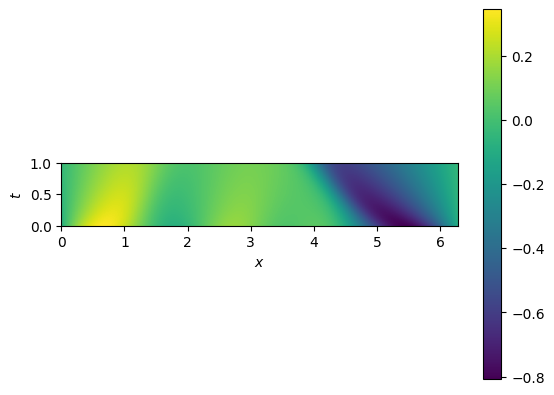

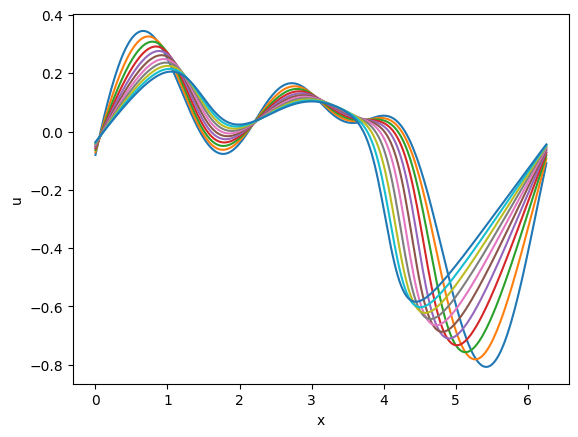

In [2]:
x,t,u = data.get_ex3_1()
u=u.T #reorder arguments u(t,x) -> u(x,t)

T = 1.
L = 2.*np.pi
N = len(x)
Nt = len(t)
dt = T/Nt

plt.imshow(u.T,origin='lower',extent=[0,L,0,T])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.figure()
plt.plot(x,u[:,::100])
plt.xlabel('x')
plt.ylabel('u')


In [5]:
#Makes a neural network to represent the solution


uNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(2,),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(16,activation='elu'),
    tf.keras.layers.Dense(16,activation='elu'),    
    tf.keras.layers.Dense(1),
])



In [6]:
xt = np.stack(np.meshgrid(x,t,indexing='ij'),axis=-1).astype('float32')
xt = np.reshape(xt,(-1,2))


#these points are in the boundary
isbc_left = xt[:,0]<1e-4
#these points are at the initial condition
isic = xt[:,1]<1e-4

#these points are in the interior
isinterior = np.logical_and(np.logical_not(isic),np.logical_not(isbc_left))

xt_bc_left = xt[isbc_left]
xt_bc_right = xt_bc_left + [L,0]
xt_ic = xt[isic]
xt_interior = xt[isinterior]


In [7]:
nu = tf.Variable(.2)
@tf.function
def PDE_res(xt,nu):
    with tf.GradientTape() as tape2:
        tape2.watch(xt)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xt)
            u_ = uNN(xt)
            u2_ = u_**2
        u_xt = tape.gradient(u_,xt)
        u2_x = tape.gradient(u2_,xt)[...,0]
        u_x = u_xt[...,0]
        u_t = u_xt[...,1]
    u_x2 = tape2.gradient(u_x,xt)[...,0]

    return tf.reduce_sum((u_t + u2_x - nu**2*u_x2)**2)

In [8]:
u_reshape = np.reshape(u,(-1,))
def data_res():
    return tf.reduce_sum((u_reshape-uNN(xt)[...,0])**2)

def IC_res():
    return tf.reduce_sum((u_reshape[xt_ic] - uNN(xt_ic)[...,0])**2)

def BC_res():
    return tf.reduce_sum((uNN(xt_bc_left) -uNN(xt_bc_left))**2)
    
def res(nu):
    return 1000*data_res()  + PDE_res(xt_interior,nu) + 1000*BC_res()


In [9]:
opt = tf.keras.optimizers.Adam(1e-3)
# @tf.function
def train():
    with tf.GradientTape() as tape:
        tape.watch(uNN.trainable_variables+[nu])
        res_ = res(nu) 
    grad_ = tape.gradient(res_,uNN.trainable_variables+[nu])
    opt.apply_gradients(zip(grad_,uNN.trainable_variables+[nu]))
    return res_

In [10]:
for _ in range(5000):
    print(train())

tf.Tensor(82121064.0, shape=(), dtype=float32)
tf.Tensor(55376260.0, shape=(), dtype=float32)
tf.Tensor(36139460.0, shape=(), dtype=float32)
tf.Tensor(24381414.0, shape=(), dtype=float32)
tf.Tensor(19466688.0, shape=(), dtype=float32)
tf.Tensor(19799434.0, shape=(), dtype=float32)
tf.Tensor(22736346.0, shape=(), dtype=float32)
tf.Tensor(25615364.0, shape=(), dtype=float32)
tf.Tensor(26840504.0, shape=(), dtype=float32)
tf.Tensor(26057716.0, shape=(), dtype=float32)
tf.Tensor(23710744.0, shape=(), dtype=float32)
tf.Tensor(20555974.0, shape=(), dtype=float32)
tf.Tensor(17345494.0, shape=(), dtype=float32)
tf.Tensor(14659196.0, shape=(), dtype=float32)
tf.Tensor(12831437.0, shape=(), dtype=float32)
tf.Tensor(11939226.0, shape=(), dtype=float32)
tf.Tensor(11837803.0, shape=(), dtype=float32)
tf.Tensor(12235076.0, shape=(), dtype=float32)
tf.Tensor(12788325.0, shape=(), dtype=float32)
tf.Tensor(13197720.0, shape=(), dtype=float32)
tf.Tensor(13271923.0, shape=(), dtype=float32)
tf.Tensor(129

KeyboardInterrupt: 

Text(0, 0.5, '$t$')

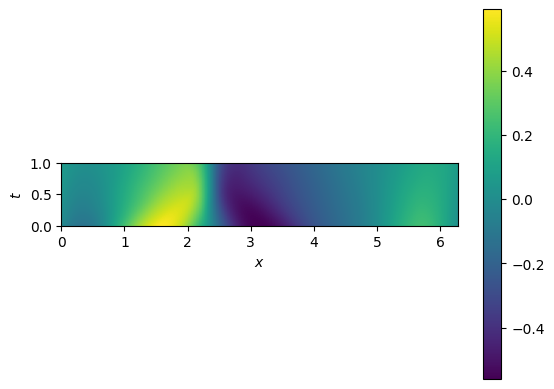

In [66]:
plt.imshow(tf.reshape(uNN(xt),(256,1001)).numpy().T,origin='lower',extent=[0,L,0,T])
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

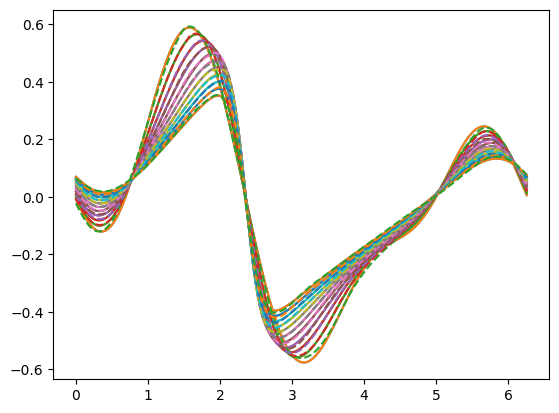

In [67]:
plt.plot(x,u[:,::100])
plt.plot(x,u[:,::100])
plt.plot(x,tf.reshape(uNN(xt),(256,1001))[:,::100],'--')

In [68]:
print('estimated viscosity,',nu.numpy()**2)
print('true viscosity,',0.1)

estimated viscosity, 0.008700048302832164
true viscosity, 0.1
